# 9 - Synthetic Control Analysis
hsujulia
4april2022

Let's do some synthetic control using CPS data. 
This notebook is inspired by (https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/15-Synthetic-Control.ipynb) 



In [2]:
from SyntheticControlMethods import Synth, DiffSynth

In [3]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


In [4]:
os.getcwd()

'/Users/hsujulia/Documents/GitHub/causalinference_crashcourse/Notebooks'

In [11]:
df = pd.read_pickle('/Users/hsujulia/Documents/GitHub/causalinference_crashcourse/Notebooks/9 Synthetic Control - CPS Data')

## 1. Set up a fake treatment.
Let's pick NJ to be our placebo state, where our outcome is unemployment rate. Then we will use synthetic control of a pre-treatment period to figure out what the synthetic control would look like, then compare the actual and predicted outcome.

We'll start by plotting the unemployment rate over our dataset, then let's apply a fake treatment to the unemployment rate at a given time frame.

In [12]:
df = df.reset_index()

Text(0.5, 0.98, 'Unemployment Rate in 2021')

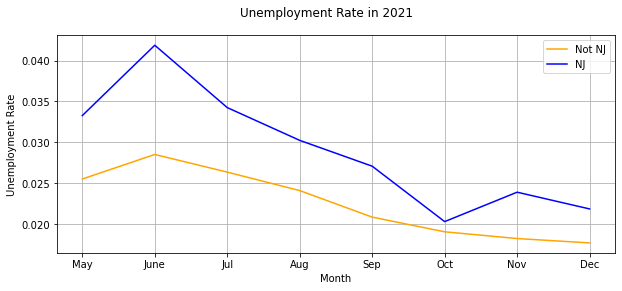

In [13]:
df['NJ_not'] = (df['state']=='NJ')
df_plot = df.groupby(['NJ_not','hryear4','hrmonth'])['laborforce_unemp'].mean().to_frame()
df_plot.reset_index(inplace=True)
fig,ax = plt.subplots(figsize=(10,4))
ax.plot( df_plot.loc[df_plot['NJ_not']==False]['hrmonth'], df_plot.loc[df_plot['NJ_not']==False]['laborforce_unemp'], 
            color='orange', label='Not NJ')
ax.plot( df_plot.loc[df_plot['NJ_not']==True]['hrmonth'], df_plot.loc[df_plot['NJ_not']==True]['laborforce_unemp'], 
        color='blue', label='NJ')
ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(5,12.1,1))
ax.set_xticklabels(['May','June','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid()
ax.legend(loc='upper right')
fig.suptitle('Unemployment Rate in 2021')


Let's decide Nov-2021 as the treatment time, with Dec-2021 as when the treatment effect is observed.

In [14]:
df['treatment'] = (df['hrmonth'] >= 12)

In [15]:
features = [
       'hefaminc_0k_15k','hefaminc_15k_50k', 'hefaminc_50k_100k', 'hefaminc_100kplus',
#        'laborforce_no', 'laborforce_unemp', 'laborforce_ft', 'laborforce_pt',
       'marriage', 'rent', 'agri', 'educ_lesshs', 'educ_someAA', 'educ_BA',
       'educ_grad', 'prernwa']


In [16]:
####
## Do some feature selection of the outcome
####
lcv = LassoCV(cv=5, normalize=True)
lcv_fit = lcv.fit(y=df['laborforce_employed'],X=df[features[1:]])
selected_features = []
for f,p in zip(features[1:],lcv_fit.coef_):
    if p !=0:
        print('{0} {1:10.7f}'.format(f,p))
        selected_features.append(f)
    

hefaminc_15k_50k  0.1507036
hefaminc_50k_100k  0.2700561
hefaminc_100kplus  0.1698928
marriage  0.0338663
agri  0.9952903
educ_lesshs -0.2363124
educ_someAA -0.0693964
educ_BA  0.1921779
educ_grad -0.1708637
prernwa  0.0000069


In [17]:
## Now bring in functions needed to calculate weights for synthetic control

from typing import List
from operator import add
from toolz import reduce, partial

## Define loss function
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights



In [18]:
def estimate_treatment(data, state, synth):
    return data.loc[(data['state']==state) & (data['hrmonth']==12) ]['laborforce_unemp'].values[0] - synth[-1]
def assign_treat(data, state, eff):
    ##Baseline value before we add a treatment
    baseline = data.loc[(data['state']==state) & (data['hrmonth']==12) ]['laborforce_unemp'].values[0]
    
    ## Create a copy of the outcome which will allow us to loop through more scenarios better
    data['laborforce_unempXXX'] = data['laborforce_unemp'].values
    ## Add the treatment
    data.loc[(data['state']==state) & (data['hrmonth']==12) , 'laborforce_unempXXX'] = baseline+eff


In [22]:
df.sort_values(by=['state','hrmonth'], ascending=True, inplace=True)

In [29]:

sc = Synth(dataset=df[['laborforce_unemployed','state','hrmonth']], 
      outcome_var="laborforce_unemployed", 
      id_var="state", 
      time_var= "hrmonth", 
      treatment_period=8, 
      treated_unit='NJ',  
      n_optim=100,
     exclude_columns = [])

## Weights
sc.original_data.weight_df


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERR


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ER


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERR


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F = 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERR


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables 


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ER


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ER


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ERROR in validate_data: Lower bound at index 0 is greater than upper bound: -1.0000e+30 > -inf
ERROR in osqp_setup: Problem data validation.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=     Infinity    |proj g|=          NaN

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     21      1     0     0         NaN    Infinity
  F =                  Infinity

ABNORMAL_TERMINATION_IN_LNSRCH                              
ERROR in validate_data: Lower bound at index 0 is gre


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


AttributeError: 'NoneType' object has no attribute 'T'

In [ ]:
def sc_model2():
    
    sc = Synth(data=df, 
          outcome_var="laborforce_unemployed", 
          id_var="state", 
          time_var= "hrmonth", 
          treatment_period=12, 
          treated_unit=st_input,  
          n_optim=100,
         exclude_columns = [])
    
    ## Weights
    sc.original_data.weight_df
    

In [210]:
def sc_model(st_input,print_diag=False):
    df['treatment_state'] = (df['state']==st_input)

    ####
    ## Make your data
    ####
    inverted_df = (df.query("~treatment") # filter pre-intervention period
                .pivot(index='state', columns="hrmonth")[['laborforce_unemployed']+features] # make one column per year and one row per state
                .T) # flip the table to have one column per state

    y = inverted_df[st_input]['laborforce_unemployed']
    X = inverted_df[[p for p in inverted.columns if p != st_input ]].loc[['laborforce_unemployed']]
    if print_diag==True:
        display(y.head())
        display(X.head(20))
    ####
    ## Calculate weights
    ####
    nj_weights = get_w(X, y)
    if print_diag==True:
        print("Sum:", nj_weights.sum())
        for w, p in zip(nj_weights, X.columns):
            if (w > 0.1**3):
                print(p, np.round(w, 3))

    synth = df.query("~treatment_state").pivot(index='state', columns="hrmonth")["laborforce_unemployed"].values.T.dot(nj_weights)

    ####
    ## calculate treatment estimate
    ####
    est = estimate_treatment(df, st_input, synth)
    return {'estimate':est, 'synthetic trend':synth, 'weights':nj_weights}

In [ ]:
## Do a Fisher exact test and cycle through all the states

In [226]:
state_list = list(df.state.value_counts().index)
placebo_trend = {}
placebo_est = []
for s in state_list:
    if s != 'NJ':
        adk = sc_model(s,print_diag=False)
        placebo_trend[s]=adk['synthetic trend']
        placebo_est.append(adk['estimate'])
    else:
        nj_estimate = sc_model(s,print_diag=False)

Text(0.5, 0.98, 'Unemployment Rate in 2021 with *no treatment effect* ')

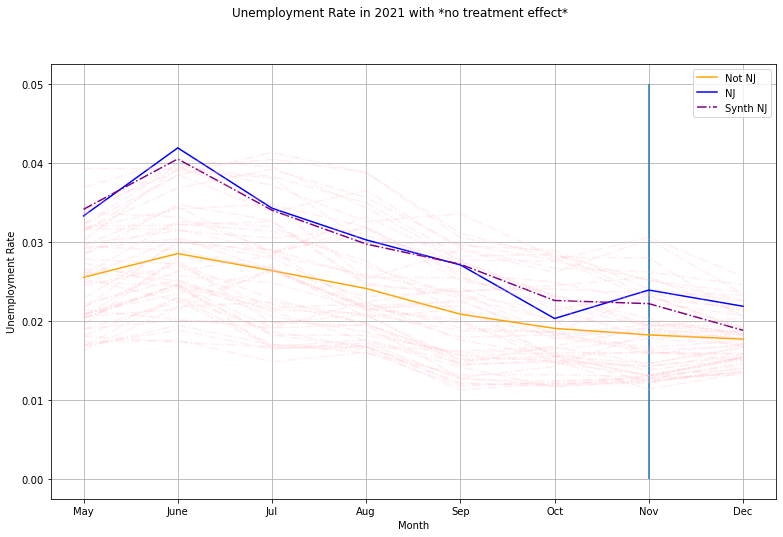

In [240]:

fig,ax = plt.subplots(figsize=(13,8))

ax.plot( df_plot.loc[df_plot['NJ_not']==False]['hrmonth'], df_plot.loc[df_plot['NJ_not']==False]['laborforce_unemp'], 
            color='orange', label='Not NJ')
ax.plot( df_plot.loc[df_plot['NJ_not']==True]['hrmonth'], df_plot.loc[df_plot['NJ_not']==True]['laborforce_unemp'], 
        color='blue', label='NJ')

for s in state_list:
    if s =='NJ':
        ax.plot( np.arange(5,12.1,1), nj_estimate['synthetic trend'],
                linestyle='-.', color='purple',label='Synth NJ')
    else:    
        ax.plot( np.arange(5,12.1,1), placebo_trend[s],
                linestyle='-.', alpha=0.25, color='pink')


ax.vlines(x=11, ymin=0, ymax = 0.05)

ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(5,12.1,1))
ax.set_xticklabels(['May','June','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid()
ax.legend(loc='upper right')
fig.suptitle('Unemployment Rate in 2021 with *no treatment effect* ')


Calculate the p-value by calculating how many estimates are less than the NJ estimate.

In [239]:
pvalue = (placebo_est < nj_estimate['estimate']).sum() / len(placebo_est)
print('P-value is {0:5.3f}'.format(pvalue) )

P-value is 0.780
